

### О задании
На сайтах для поиска работы можно найти сотни тысяч объявлений, каждое из которых состоит из пространного описания вакансии и предлагаемой зарплаты. Есть ли связь между описанием и зарплатой? Существуют ли определенные слова, которые наиболее сильно характеризуют зарплату? Можно ли найти другие информативные факторы? Вам предстоит ответить на эти вопросы, проанализировав выборку объявлений о работе в Великобритании.

Практическое задание 2 посвящено работе с текстовыми данными и категориальными признаками и задачам бинарной классификации. Вы научитесь:
 * работать с категориальными признаками;
 * строить вещественные представления текстовых данных;
 * обучать и строить прогнозы линейных классификаторов при помощи scikit-learn и Vowpal Wabbit;
 * тестировать модели и проводить оценку качества в задачах бинарной классификации.


### Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов. Кроме того, некоторые из заданий являются опциональными (необязательными), однако за их выполнение можно получить дополнительные баллы, которые позднее будут учитываться при проставлении оценок автоматом по курсу.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце Вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

## Данные

Как было упомянуто ранее, в рамках данного задания мы будем решать задачу бинарной классификации для предсказания уровня заработной платы по тексту объявления о вакансии на примере набора данных с соревнования [Adzuna - Job Salary Prediction](https://www.kaggle.com/c/job-salary-prediction). Для начала пройдите по [ссылке](https://www.kaggle.com/c/job-salary-prediction/data) и скачайте файл Train_rev1 (при необходимости, зарегистрируйтесь на Kaggle).

Посмотрим на данные в файле и загрузим их в DataFrame:

In [5]:
%pip install mlxtend

     |████████████████████████████████| 1.3 MB 4.6 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [1]:
%pylab inline

import pandas as pd

Populating the interactive namespace from numpy and matplotlib


In [2]:
# print first 2 rows from Train_rev1.csv
!head -n 2 Train_rev1.csv

In [3]:
df = pd.read_csv('Train_rev1.csv', sep=',')
print(df.shape)
df.head()

(244768, 12)


,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName
0,12612628,Engineering Systems Analyst,Engineering Systems Analyst Dorking Surrey Sal...,"Dorking, Surrey, Surrey",Dorking,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk
1,12612830,Stress Engineer Glasgow,Stress Engineer Glasgow Salary **** to **** We...,"Glasgow, Scotland, Scotland",Glasgow,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 35000/annum 25-35K,30000,cv-library.co.uk
2,12612844,Modelling and simulation analyst,Mathematical Modeller / Simulation Analyst / O...,"Hampshire, South East, South East",Hampshire,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 40000/annum 20-40K,30000,cv-library.co.uk
3,12613049,Engineering Systems Analyst / Mathematical Mod...,Engineering Systems Analyst / Mathematical Mod...,"Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 30000/annum 25K-30K negotiable,27500,cv-library.co.uk
4,12613647,"Pioneer, Miser Engineering Systems Analyst","Pioneer, Miser Engineering Systems Analyst Do...","Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk


В оригинальной постановке предлагается рассматривать признак SalaryNormalized как целевой и решать задачу регрессии, однако в рамках данного задания мы сведём её к задаче бинарной классификации, разделив объекты на 2 группы: объявления о вакансиях с низкой и высокой зарплатами соответственно.

<img src = "http://salt.uaa.alaska.edu/kath/kti/mean_median2.gif">

В качестве порога разбиения объектов на группы будем рассматривать медиану признака SalaryNormalized. Заметим, что таким образом мы автоматически получим задачу классификации со сбалансированными классами:

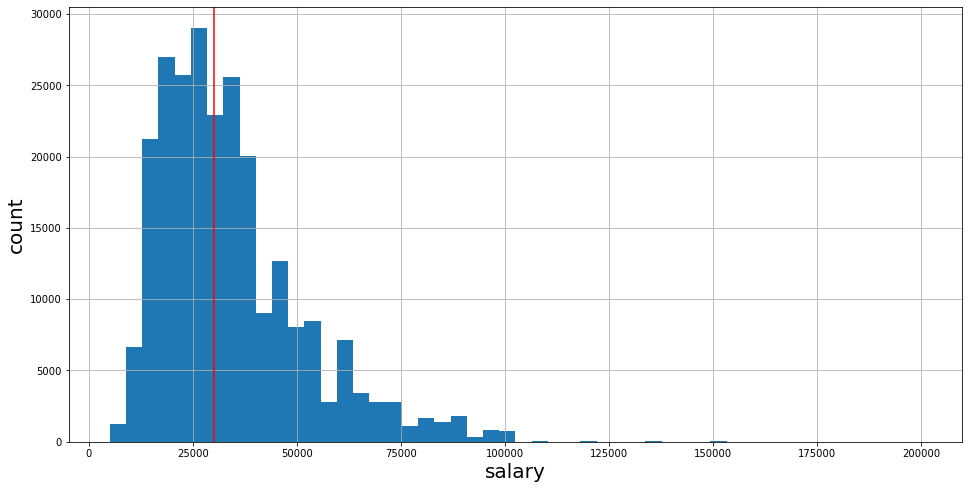

In [4]:
# salary histogramm
median = np.median(df['SalaryNormalized'])

figsize(16,8)
plt.hist(df['SalaryNormalized'], bins=50)
plt.axvline(median, c='r')
plt.xlabel('salary', fontsize=20)
plt.ylabel('count', fontsize=20)
plt.grid()

Осуществим последние шаги по подготовке датасета:
- бинаризуем признак SalaryNomalized по описанному ранее порогу;
- исключим из выборки признак SalaryRaw, чтобы устранить утечку целевой переменной в признаки.

In [5]:
df['SalaryNormalized'] = (df['SalaryNormalized'] > median).astype(int)
df.drop('SalaryRaw', axis=1, inplace=True)
df.head()

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryNormalized,SourceName
0,12612628,Engineering Systems Analyst,Engineering Systems Analyst Dorking Surrey Sal...,"Dorking, Surrey, Surrey",Dorking,NaN,permanent,Gregory Martin International,Engineering Jobs,0,cv-library.co.uk
1,12612830,Stress Engineer Glasgow,Stress Engineer Glasgow Salary **** to **** We...,"Glasgow, Scotland, Scotland",Glasgow,NaN,permanent,Gregory Martin International,Engineering Jobs,0,cv-library.co.uk
2,12612844,Modelling and simulation analyst,Mathematical Modeller / Simulation Analyst / O...,"Hampshire, South East, South East",Hampshire,NaN,permanent,Gregory Martin International,Engineering Jobs,0,cv-library.co.uk
3,12613049,Engineering Systems Analyst / Mathematical Mod...,Engineering Systems Analyst / Mathematical Mod...,"Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,0,cv-library.co.uk
4,12613647,"Pioneer, Miser Engineering Systems Analyst","Pioneer, Miser Engineering Systems Analyst Do...","Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,0,cv-library.co.uk


#### 1. (0 баллов) Разбейте получившуюся выборку на обучающую и контрольную в соотношении 70/30 с использованием перемешивания объектов.

При разбиении используйте значение параметра random_state=42.

In [6]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, train_size=0.7, test_size=0.3, random_state = 42)

## Векторизация

Как правило, модели, используемые в машинном обучении, применяются в предположении, что матрица "объект-признак" является вещественнозначной. Поэтому при работе с категориальными признаками и текстами сперва их необходимо привести к вещественному виду.

Заметим, что в нашей задаче есть признаки, являющиеся текстами произвольной природы (Title, FullDescription), и категориальные признаки, принимающие ограниченное число значений (ContractType, Category и др.).

Самый простой и понятный способ преобразования текстовых данных — векторизация. В этом случае для каждого слова, встречающегося в некотором набре текстов мы создаём отдельный новый признак, который будет равен $1$, когда слово встречается в заданном объекте, и $0$ – в противном случае.

#### 2. (0.5 балла) Создайте текстовое описание объектов обучающей и контрольной выборок, объединив значения всех признаков каждого объекта выборки через символы пробела. После этого получите признаковое описание объектов, осуществив векторизацию получившихся текстов при помощи [CountVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html), обучив его на обучающей выборке и применив на контрольной.

In [8]:
def combine_columns(DataFrame, Columns):
    return DataFrame[Columns].apply(lambda x: ' '.join(x.astype(str)), axis=1)

def split(vector, DataFrame, DataFrame_Train, DataFrame_Test, Columns):
    text = combine_columns(DataFrame, Columns)
    vectorizer.fit(text)
    X_train = vectorizer.transform(combine_columns(DataFrame_Train, Columns))
    X_test = vectorizer.transform(combine_columns(DataFrame_Test, Columns))
    y_train = DataFrame_Train['SalaryNormalized']
    y_test = DataFrame_Test['SalaryNormalized']
    return X_train, X_test, y_train, y_test

In [9]:
from sklearn.feature_extraction.text import CountVectorizer

columns = ['LocationNormalized', 'ContractType', 'ContractTime', 'Category', 'SourceName'] 

vectorizer = CountVectorizer()
X_train1, X_test1, y_train, y_test = split(vectorizer, df, df_train, df_test, columns)

#### 3. (1.5 балла) Обучите следующие модели на обучающей выборке:
 - [логистическую регрессию](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) из модуля sklearn с параметрами по умолчанию;
 - логистическую регрессию при помощи Vowpal Wabbit с параметрами по умолчанию.

In [10]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(max_iter=1000)
lr_prediction1 = logreg.fit(X_train1, y_train).predict(X_test1)

#### 4. (0.5 балла) Вычислите значения ROC-AUC, [F-меры](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html), а также постройте [матрицу ошибок](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) для каждой из построенных в п. 3 моделей на контрольной выборке. Сравните построенные модели по качеству их работы.

In [11]:
from sklearn.metrics import roc_curve as roc, auc, confusion_matrix, classification_report
from mlxtend.plotting import plot_confusion_matrix

def roc_auc(y, lr):
    r_x, r_y, _ = roc(y, lr)
    plt.plot(r_x, r_y, label='ROC-AUC кривая (area = %0.2f)' % auc(r_x, r_y))
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.legend(loc=0)
    plt.show()
    
def conf_matrix(y, lr):
    plot_confusion_matrix(confusion_matrix(lr, y), show_absolute=True, show_normed=True, colorbar=True)
    plt.title("Матрица ошибок")
    plt.show()

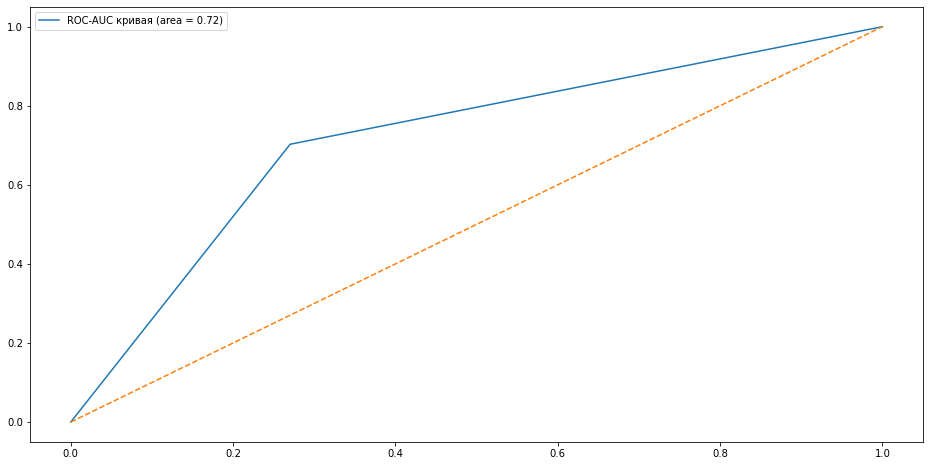

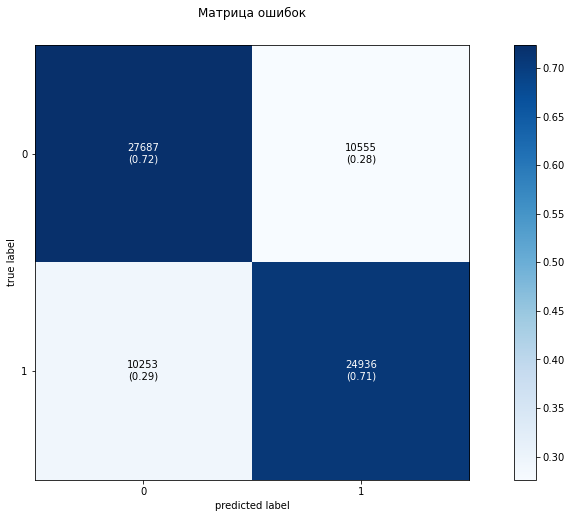


		Краткая информация

              precision    recall  f1-score   support

           0       0.72      0.73      0.73     37940
           1       0.71      0.70      0.71     35491

    accuracy                           0.72     73431
   macro avg       0.72      0.72      0.72     73431
weighted avg       0.72      0.72      0.72     73431



In [12]:
roc_auc(y_test, lr_prediction1)
conf_matrix(y_test, lr_prediction1)
print("\n\t\tКраткая информация\n")
print(classification_report(y_test, lr_prediction1))

#### 5. (1 балл) Отсортируйте веса признаков для модели логистической регрессии из scikit-learn, полученной в п. 2. Какие слова из встречающихся в выборке имеют наибольшее/наименьшее влияние на значение целевой переменной? Проинтерпретируйте полученный результат.

In [13]:
from sklearn.feature_selection import SelectFromModel

def sort_weights(X, y, num):
    selector = SelectFromModel(estimator=LogisticRegression()).fit(X, y)
    d = {} 
    for i in range(len(selector.estimator_.coef_[0])):
        d[i] = selector.estimator_.coef_[0][i]
    sort_selector = {k: v for k, v in sorted(d.items(), key=lambda item: item[1], reverse=True)}
    reverse_vectorizer = dict(zip(vectorizer.vocabulary_.values(), vectorizer.vocabulary_.keys()))
    for i in range(num):
        print(reverse_vectorizer[list(sort_selector.keys())[i]], " \t\t", sort_selector[list(sort_selector.keys())[i]])

In [14]:
sort_weights(X_train1, y_train, 100)

theladders  		 6.63812357933186
gaydon  		 3.232370865615059
totallyexec  		 2.6399222680485925
actuaryjobs  		 2.542135934698316
careersinaudit  		 2.342367557540113
wileyjobnetwork  		 1.9304986817568228
gponline  		 1.896177599894347
efinancialcareers  		 1.765557323087646
rtmjobs  		 1.7648221748294646
icaewjobs  		 1.676348606435549
stevenage  		 1.5832013947831813
seascale  		 1.5799280943545744
ijobs  		 1.542863746205792
llandaff  		 1.51858538876155
oilcareers  		 1.4682721573727169
hackney  		 1.4631332134664747
ealing  		 1.4453833003595056
london  		 1.4365960565637725
covent  		 1.4322956227989234
finchley  		 1.4232504354263464
gipsy  		 1.4226517832445096
england  		 1.3780704704404914
hooke  		 1.3510122967001674
malling  		 1.3199762077912094
lambeth  		 1.3158771582218003
uxbridge  		 1.3093757057566515
peoplemanagement  		 1.2501923913037676
it  		 1.2428077634913703
wales  		 1.2166127498309434
greenwich  		 1.1977638141598783
cumbria  		 1.1906398792894006
hertford

/srv/conda/envs/notebook/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


#### 6. (0.5 доп. балла) Отсортируйте веса признаков для модели логистической регрессии, полученной в п. 2 при помощи Vowpal Wabbit. Какие слова из встречающихся в выборке имеют наибольшее/наименьшее влияние на значение целевой переменной? Проинтерпретирйте полученный результат.

In [ ]:
# Your code here

## TF-IDF

Ещё один способ работы с текстовыми данными — [TF-IDF](https://en.wikipedia.org/wiki/Tf–idf) (**T**erm **F**requency–**I**nverse **D**ocument **F**requency). Рассмотрим коллекцию текстов $D$.  Для каждого уникального слова $t$ из документа $d \in D$ вычислим следующие величины:

1. Term Frequency – количество вхождений слова в отношении к общему числу слов в тексте:
$$\text{tf}(t, d) = \frac{n_{td}}{\sum_{t \in d} n_{td}},$$
где $n_{td}$ — количество вхождений слова $t$ в текст $d$.
1. Inverse Document Frequency
$$\text{idf}(t, D) = \log \frac{\left| D \right|}{\left| \{d\in D: t \in d\} \right|},$$
где $\left| \{d\in D: t \in d\} \right|$ – количество текстов в коллекции, содержащих слово $t$.

Тогда для каждой пары (слово, текст) $(t, d)$ вычислим величину:
$$\text{tf-idf}(t,d, D) = \text{tf}(t, d)\cdot \text{idf}(t, D).$$

Отметим, что значение $\text{tf}(t, d)$ корректируется для часто встречающихся общеупотребимых слов при помощи значения $\text{idf}(t, D).$

Признаковым описанием одного объекта $d \in D$ будет вектор $\bigg(\text{tf-idf}(t,d, D)\bigg)_{t\in V}$, где $V$ – словарь всех слов, встречающихся в коллекции $D$.

#### 7. (0.5 балла) Создайте текстовое описание объектов обучающей и контрольной выборок, объединив значения всех признаков каждого объекта выборки через символы пробела. После этого получите признаковое описание объектов, вычислив вектор tf-idf для каждого объекта помощи [TfidfVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html), обучив его на обучающей выборке и применив на контрольной.

In [ ]:
# Your code here

#### 8. (0 баллов) Обучите следующие модели на обучающей выборке:
- [логистическую регрессию](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) из модуля sklearn с параметрами по умолчанию;
- логистическую регрессию при помощи Vowpal Wabbit с параметрами по умолчанию.

In [ ]:
# Your code here

#### 9. (0.5 балла) Вычислите значения ROC-AUC, [F-меры](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html), а также постройте [матрицу ошибок](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) для каждой из построенных в п. 8 моделей на контрольной выборке. Сравните построенные модели по качеству их работы.

In [ ]:
# Your code here

#### 10. (0.5 балла) Сравните значения метрик из п. 9 со значениями, полученными в п. 5, и сравните соответствующие модели по качеству из работы.

**Ответ**:

#### 11. (1 балл) Отсортируйте веса признаков для модели логистической регрессии из scikit-learn, полученной в п. 8. Какие слова из встречающихся в выборке имеют наибольшее/наименьшее влияние на значение целевой переменной? Проинтерпретирйте полученный результат.

In [ ]:
# Your code here

#### 12. (0.5 доп. балла) Отсортируйте веса признаков для модели логистической регрессии, полученной в п. 8 при помощи Vowpal Wabbit. Какие слова из встречающихся в выборке имеют наибольшее/наименьшее влияние на значение целевой переменной? Проинтерпретирйте полученный результат.

In [ ]:
# Your code here

## Счётчики

Ранее в рамках данного задания при построении моделей мы объединяли значения всех признаков в единую строку, что предполагает равноправность всех признаков. Однако заметим, что в этом случае мы допускаем потерю информации: слово "Glasgow" может по-разному влиять на зарплату, если оно находится в названии объявления и в геолокации. Чтобы устранить этот недостаток, при создании текстового описания объекта будем объединять только значения признаков Title и FullDescription, а остальные будем рассматривать как категориальные. При этом с полученным текстовым описанием объекта будем работать, как раньше (при помощи векторизации или tf-idf), а для кодирования категориальных признаков используем **счётчики**.

Идея этого метода состоит в том, чтобы заменить значение категориального признака на вероятность того, что объект с данным значением признака относится к положительному классу. Опишем эту идею более формально. Пусть у нас есть выборка $X = \{ (x_i, y_i) \}_{i=1}^l,$ и $j$-ый признак принимает значения из множества $U_j = \{ u_{jn}\}_{n=1}^{N_j},$ где $N_j$ — количество различных значений $j$-ого признака. Пусть $x_{ij} = u_{jn},$ тогда заменим значения $j$-ого категориального признака объекта $x_i$ на следующую оценку: 
$$\hat{P}(y_i=+1|x_{ij}=u_{jn}) = \frac{\sum_{m=1}^l \left[ x_{mj} = u_{jn} \right] \left[ y_m = +1 \right]}{\sum_{m=1}^l \left[ x_{mj} = u_{jn} \right]}.$$

Однако заметим, что при таком способе формирования счётчиков мы учитываем в формуле для объекта $x_i$ его метку $y_i$, тем самым вносим информацию об ответе в признаки. Чтобы устранить этот недостаток, при вычислении счётчика будем исключать из рассмотрения текущий объект, т.е. рассматривать следующую оценку:
$$\hat{P}(y_i=+1|X_{ij}=u_{jn}) = \frac{\sum_{m=1, \\ m \ne i}^l \left[ x_{mj} = u_{jn} \right] \left[ y_m = +1 \right]}{\sum_{m=1, \\ m \ne i}^l \left[ x_{mj} = u_{jn} \right]},$$

#### 13. (0.5 балла) Создайте текстовое описание объектов обучающей и контрольной выборок, объединив значения признаков Title и FullDescription каждого объекта выборки через символ пробела, после чего перейдите к признаковому описанию объектов, вычислив вектор tf-idf аналогично п. 7.

In [ ]:
# Your code here

#### 14. (1 балл) Закодируйте категориальные признаки (все, кроме Title и FullDescription) при помощи [one-hot encoding](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html), после чего обучите логистическую регрессию (при помощи scikit-learn или Vowpal Wabbit) на обучающей выборке. Вычислите значения ROC-AUC, [F-меры](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html), а также постройте [матрицу ошибок](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) для полученной модели на контрольной выборке. 

In [ ]:
# Your code here

#### 15. (2 балла) Для выборки, полученной в п. 13, закодируйте категориальные признаки (все, кроме Title и FullDescription) при помощи счётчиков, после чего обучите логистическую регрессию (при помощи scikit-learn или Vowpal Wabbit) на обучающей выборке. Вычислите значения ROC-AUC, [F-меры](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html), а также постройте [матрицу ошибок](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) для полученной модели на контрольной выборке. 

Уделите внимание оптимальности вычисления счётчиков!

In [ ]:
# Your code here

#### 16. (0.5 балла) Сравните значения метрик из п. 15 со значениями, полученными в п. 14, и сделайте вывод о качестве классификации для каждого из методов кодирования категориальных признаков.

**Ответ:**

## Подбор гиперпараметров

#### 17. (1.5 доп. балла) Разбейте обучающую выборку, полученную в п. 13, на обучающую и валидационную в отношении 80/20, после чего подберите оптимальное количество фолдов, используемое при кодировании категориальных признаков (всех, кроме Title и FullDescription), путём оптимизации значения accuracy на валидационной выборке. Используйте следующие модели, аналогично также подобрав оптимальные значения указанных гиперпараметров:
- логистическую регрессию из модуля sklearn с подбором коэффициента регуляризации;
- логистическую регрессию при помощи Vowpal Wabbit с подбором следующих гиперпараметров:
    - коэффициент регуляризации (--l2);
    - количество эпох (--passes);
    - длина градиентного шага (-l);
    - длина N-грамм (--ngram).

In [ ]:
# Your code here

#### 18. (0.5 доп. балла) Обучите указанные выше модели на обучающей выборке для оптимальных значений гиперпараметров, найденных в п. 17, после чего для каждой из моделей вычислите значения ROC-AUC, F-меры, а также постройте матрицу ошибок на контрольной выборке. Как качество классификации при помощи полученных в данном разделе моделей соотносится с моделями, полученными в предыдущих разделах?

In [ ]:
# Your code here

Здесь вы можете поделиться своими мыслями по поводу этого задания.

А здесь — вставить вашу вторую любимую смешную картинку.

А здесь — посоветовать преподавателям хороший фильм или сериал.